In [31]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Reshape
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adam, Adadelta
import numpy as np
import pandas as pd
from keras.utils import *
import time
from keras.models import Sequential
import tempfile
from keras.models import save_model, load_model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [2]:
train_data=pd.read_csv('train.csv')

In [3]:
train_data.head()

,label,feature
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
train_data.shape

(28709, 2)

In [5]:
pixel=train_data['feature'].values
label=train_data['label'].values

In [6]:
pixel.shape

(28709,)

In [7]:
label.shape

(28709,)

In [8]:
pixel[0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [9]:
type(pixel)

numpy.ndarray

In [10]:
pixels=[ np.fromstring(x, dtype=float, sep=' ') for x in pixel ]

In [11]:
pixels[0]

array([  70.,   80.,   82., ...,  106.,  109.,   82.])

In [12]:
pixels=np.array(pixels)
pixels=pixels.reshape(pixels.shape[0],48,48,1)
pixels=pixels.astype('float32')
pixels=pixels/255

In [13]:
pixels.shape

(28709, 48, 48, 1)

In [14]:
# 将类向量转换为二进制类矩阵
label = np_utils.to_categorical(label, 7)
label.shape

(28709, 7)

In [15]:
#分成训练集和测试集
id=int(pixels.shape[0]*0.8)
X_train=pixels[:id]
X_test=pixels[id:]
y_train=label[:id]
y_test=label[id:]

In [16]:
X_train.shape

(22967, 48, 48, 1)

In [17]:
X_test.shape

(5742, 48, 48, 1)

In [18]:
y_train.shape

(22967, 7)

In [19]:
# 定义超参数
n_filter=32
batch_size = 256
nb_classes = 7  # 分类树
nb_epoch = 120  # 训练轮数

img_rows, img_cols = 48, 48  # 图片维数
kernel_size = (8, 8)  # 卷积核大小
pool_size = (3, 3)  # 最大池化，池化核大小


model=Sequential()
model.add(Conv2D(n_filter,kernel_size,strides=1,input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Conv2D(n_filter,kernel_size,strides=1,input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())  # Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡
model.add(Dense(526))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(526))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# 模型编译
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 41, 41, 32)        2080      
_________________________________________________________________
activation_1 (Activation)    (None, 41, 41, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          65568     
_________________________________________________________________
activation_2 (Activation)    (None, 6, 6, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
__________

In [20]:
# 模型训练
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,validation_data=(X_test, y_test))

# 模型评估或模型预测
score = model.evaluate(X_train, y_train)
print('\nTrain score:', score[0])  # 损失值  Test score: 
print('Train accuracy:', score[1])  # 准确率  Test accuracy: 
score = model.evaluate(X_test, y_test,)
print('\nTest score:', score[0])  # 损失值  Test score: 
print('Test accuracy:', score[1])  # 准确率  Test accuracy: 


Train on 22967 samples, validate on 5742 samples
Epoch 1/300
22967/22967 [==============================] - 5s - loss: 1.8444 - acc: 0.2372 - val_loss: 1.8227 - val_acc: 0.2517
Epoch 2/300
22967/22967 [==============================] - 2s - loss: 1.8193 - acc: 0.2491 - val_loss: 1.8041 - val_acc: 0.2517
Epoch 3/300
22967/22967 [==============================] - 2s - loss: 1.7920 - acc: 0.2595 - val_loss: 1.7335 - val_acc: 0.2767
Epoch 4/300
22967/22967 [==============================] - 2s - loss: 1.7045 - acc: 0.3168 - val_loss: 1.6220 - val_acc: 0.3615
Epoch 5/300
22967/22967 [==============================] - 2s - loss: 1.6388 - acc: 0.3544 - val_loss: 1.5930 - val_acc: 0.3920
Epoch 6/300
22967/22967 [==============================] - 2s - loss: 1.5937 - acc: 0.3786 - val_loss: 1.5227 - val_acc: 0.4171
Epoch 7/300
22967/22967 [==============================] - 2s - loss: 1.5581 - acc: 0.3929 - val_loss: 1.4839 - val_acc: 0.4227
Epoch 8/300
22967/22967 [==============================

22967/22967 [==============================] - 2s - loss: 1.1087 - acc: 0.5821 - val_loss: 1.1900 - val_acc: 0.5430
Epoch 65/300
22967/22967 [==============================] - 2s - loss: 1.1161 - acc: 0.5791 - val_loss: 1.1873 - val_acc: 0.5512
Epoch 66/300
22967/22967 [==============================] - 2s - loss: 1.1113 - acc: 0.5797 - val_loss: 1.1802 - val_acc: 0.5509
Epoch 67/300
22967/22967 [==============================] - 2s - loss: 1.1144 - acc: 0.5785 - val_loss: 1.1968 - val_acc: 0.5482
Epoch 68/300
22967/22967 [==============================] - 2s - loss: 1.0966 - acc: 0.5902 - val_loss: 1.2339 - val_acc: 0.5388
Epoch 69/300
22967/22967 [==============================] - 2s - loss: 1.0999 - acc: 0.5833 - val_loss: 1.2007 - val_acc: 0.5488
Epoch 70/300
22967/22967 [==============================] - 2s - loss: 1.0932 - acc: 0.5861 - val_loss: 1.1911 - val_acc: 0.5517
Epoch 71/300
22967/22967 [==============================] - 2s - loss: 1.0901 - acc: 0.5889 - val_loss: 1.2045

22967/22967 [==============================] - 2s - loss: 0.9844 - acc: 0.6350 - val_loss: 1.2129 - val_acc: 0.5575
Epoch 128/300
22967/22967 [==============================] - 2s - loss: 0.9899 - acc: 0.6273 - val_loss: 1.1897 - val_acc: 0.5590
Epoch 129/300
22967/22967 [==============================] - 2s - loss: 0.9832 - acc: 0.6330 - val_loss: 1.1983 - val_acc: 0.5547
Epoch 130/300
22967/22967 [==============================] - 2s - loss: 0.9856 - acc: 0.6338 - val_loss: 1.2173 - val_acc: 0.5573
Epoch 131/300
22967/22967 [==============================] - 2s - loss: 0.9874 - acc: 0.6316 - val_loss: 1.2146 - val_acc: 0.5536
Epoch 132/300
22967/22967 [==============================] - 2s - loss: 0.9830 - acc: 0.6300 - val_loss: 1.2154 - val_acc: 0.5557
Epoch 133/300
22967/22967 [==============================] - 2s - loss: 0.9827 - acc: 0.6323 - val_loss: 1.1862 - val_acc: 0.5566
Epoch 134/300
22967/22967 [==============================] - 2s - loss: 0.9765 - acc: 0.6320 - val_loss:

22967/22967 [==============================] - 2s - loss: 0.9135 - acc: 0.6593 - val_loss: 1.2188 - val_acc: 0.5599
Epoch 191/300
22967/22967 [==============================] - 2s - loss: 0.9198 - acc: 0.6594 - val_loss: 1.2168 - val_acc: 0.5613
Epoch 192/300
22967/22967 [==============================] - 2s - loss: 0.9200 - acc: 0.6569 - val_loss: 1.2020 - val_acc: 0.5707
Epoch 193/300
22967/22967 [==============================] - 2s - loss: 0.9182 - acc: 0.6568 - val_loss: 1.1985 - val_acc: 0.5650
Epoch 194/300
22967/22967 [==============================] - 2s - loss: 0.9273 - acc: 0.6571 - val_loss: 1.2060 - val_acc: 0.5622
Epoch 195/300
22967/22967 [==============================] - 2s - loss: 0.9103 - acc: 0.6638 - val_loss: 1.2099 - val_acc: 0.5674
Epoch 196/300
22967/22967 [==============================] - 2s - loss: 0.9208 - acc: 0.6558 - val_loss: 1.1973 - val_acc: 0.5623
Epoch 197/300
22967/22967 [==============================] - 2s - loss: 0.9260 - acc: 0.6533 - val_loss:

22967/22967 [==============================] - 2s - loss: 0.8870 - acc: 0.6752 - val_loss: 1.2132 - val_acc: 0.5634
Epoch 254/300
22967/22967 [==============================] - 2s - loss: 0.8897 - acc: 0.6677 - val_loss: 1.2133 - val_acc: 0.5641
Epoch 255/300
22967/22967 [==============================] - 2s - loss: 0.8803 - acc: 0.6763 - val_loss: 1.2230 - val_acc: 0.5597
Epoch 256/300
22967/22967 [==============================] - 2s - loss: 0.8863 - acc: 0.6704 - val_loss: 1.2378 - val_acc: 0.5613
Epoch 257/300
22967/22967 [==============================] - 2s - loss: 0.8788 - acc: 0.6752 - val_loss: 1.2105 - val_acc: 0.5665
Epoch 258/300
22967/22967 [==============================] - 2s - loss: 0.8813 - acc: 0.6748 - val_loss: 1.2202 - val_acc: 0.5643
Epoch 259/300
22967/22967 [==============================] - 2s - loss: 0.8807 - acc: 0.6739 - val_loss: 1.2179 - val_acc: 0.5639
Epoch 260/300
22967/22967 [==============================] - 2s - loss: 0.8829 - acc: 0.6727 - val_loss:

In [24]:
# 保存模型
_, fname = tempfile.mkstemp('33.h5', dir='.')
save_model(model, fname)
new_model = load_model(fname)

In [25]:
fname='tmp2k3ln4b533.h5'
new_model = load_model(fname)
# 画模型图
from keras.utils.vis_utils import plot_model
plot_model(new_model,show_shapes=True,to_file='model.png')

In [32]:
# 在分出的测试集上画出 Confusion Matrix
predictions = new_model.predict(X_test)


In [37]:
predictions[0]

array([ 0.02451207,  0.00233878,  0.02093311,  0.77501655,  0.10480295,
        0.00487964,  0.06751691], dtype=float32)

In [36]:
y_test[0]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [39]:
def find(x):
    count=0
    maxnum=0
    maxcount=0
    for i in x:
        if maxnum<i:
            maxcount=count
            maxnum=i
        count=count+1
    return maxcount
predictions=[find(x) for x in predictions]
y_test=[find(x) for x in y_test]

In [40]:
predictions[0]

3

In [41]:
y_test[0]

3

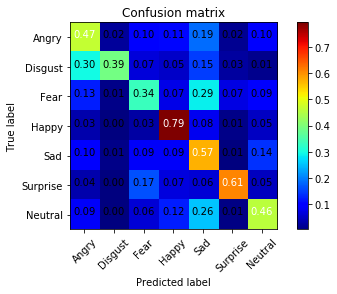

In [42]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.jet):
    """
    This function prints and plots the confusion matrix.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf_mat = confusion_matrix(y_test,predictions)

plt.figure()
plot_confusion_matrix(conf_mat, classes=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"])
plt.show()

In [26]:
# 用训练好的模型预测未知图片的情感
test_data=pd.read_csv('test.csv')

In [27]:
test_data.head()

,id,feature
0,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,1,156 184 198 202 204 207 210 212 213 214 215 21...
2,2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [28]:
test_data.shape

(7178, 2)

In [ ]:
test_id=test_data['id'].values
test_pixel=test_data['feature'].values

In [ ]:
test_pixels=[ np.fromstring(x, dtype=float, sep=' ') for x in test_pixel ]
test_pixels=np.array(test_pixels)
test_pixels=test_pixels.reshape(test_pixels.shape[0],48,48,1)
test_pixels=test_pixels.astype('float32')
test_pixels=test_pixels/255

In [ ]:
test_pixels.shape

In [ ]:
y_pred=new_model.predict(test_pixels)

In [ ]:
y_pred[2][:]

In [ ]:
def find(x):
    count=0
    maxnum=0
    maxcount=0
    for i in x:
        if maxnum<i:
            maxcount=count
            maxnum=i
        count=count+1
    return maxcount
y_label=[find(x) for x in y_pred]

In [ ]:
y_label=np.array(y_label)

In [ ]:
y_label.shape

In [ ]:
y_label[46]

In [ ]:
pd.DataFrame({"id": test_id, "label": y_label}).to_csv('submission.csv',index=False)